**Importing required libraries**

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

**Getting Train, Validation and Test datasets**

In [2]:
df = pd.read_csv('wdbc_train_normalized.csv')
dev = pd.read_csv('wdbc_dev_normalized.csv')

**Encoding Class Label (y)**

In [3]:
df['Diagnosis'] = (df['Diagnosis'] == 'M').astype(int)
dev['Diagnosis'] = (dev['Diagnosis'] == 'M').astype(int)
names = df.columns[:-1].tolist()

**Dividing the Datasets as X and Y**

In [4]:
X = df[names].values
Y = df['Diagnosis'].values.reshape(-1,1)

devX = dev[names].values
devY = dev['Diagnosis'].values.reshape(-1,1)

**Creating a Decision Tree Node class**

In [5]:
class DTNode():

    def __init__(self, attribute=None, threshold=None, leftsub=None, rightsub=None, gain=None, value=None):
        self.attribute = attribute
        self.threshold = threshold
        self.rightsub = rightsub
        self.leftsub = leftsub
        self.gain = gain
        self.value = value


**Creating a Decision Tree class with Gini and Gain as splitting techniques**

In [6]:
class DT():

    def __init__(self, max_depth=30, mode="entropy"):
        self.max_depth = max_depth
        self.mode = mode

    def splitdata(self, dataset, attribute, threshold):
        ltemp = dataset[:, attribute] <= threshold
        leftset = dataset[ltemp]
        rtemp = dataset[:, attribute] > threshold
        rightset = dataset[rtemp]
        return leftset, rightset

    def entropy(self, y):
        entropy = 0
        labels = np.unique(y)
        for label in labels:
            pl = len(y[y == label]) / len(y)
            entropy += -pl * np.log2(pl) if pl > 0 else 0
        return entropy

    def gini(self, y):
        gini = 1
        labels = np.unique(y)
        for label in labels:
            pg = len(y[y == label]) / len(y)
            gini -= pg ** 2
        return gini

    def infogain(self, parent, left, right):
        wright = len(right) / len(parent)
        wleft = len(left) / len(parent)
        weighted_en = (wleft * self.entropy(left)) + (wright * self.entropy(right))
        return self.entropy(parent) - weighted_en

    def ginigain(self, parent, left, right):
        wright = len(right) / len(parent)
        wleft = len(left) / len(parent)
        weighted_gini = (wleft * self.gini(left)) + (wright * self.gini(right))
        return self.gini(parent) - weighted_gini

    def bestsplit(self, dataset, nattributes):
        splitresult = {'gain': -1, 'attribute': None, 'threshold': None}
        for index in range(nattributes):
            values = dataset[:, index]
            thresholds = np.unique(values)
            for threshold in thresholds:
                leftdset, rightdset = self.splitdata(dataset, index, threshold)
                if len(leftdset) and len(rightdset):
                    parent = dataset[:, -1]
                    lefty, righty = leftdset[:, -1], rightdset[:, -1]

                    if self.mode == "entropy":
                        gain = self.infogain(parent, lefty, righty)
                    elif self.mode == "gini":
                        gain = self.ginigain(parent, lefty, righty)
                    if gain > splitresult["gain"]:
                        splitresult["threshold"] = threshold
                        splitresult["attribute"] = index
                        splitresult["leftset"] = leftdset
                        splitresult["rightset"] = rightdset
                        splitresult["gain"] = gain
        return splitresult

    def leafval(self, y):
        return max(y, key=list(y).count)

    def treeBuilding(self, dataset, currdepth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        nsamples, nattributes = X.shape
        if currdepth <= self.max_depth:
            splitresult = self.bestsplit(dataset, nattributes)
            if splitresult["gain"] > 0:
                leftnode = self.treeBuilding(splitresult["leftset"], currdepth + 1)
                rightnode = self.treeBuilding(splitresult["rightset"], currdepth + 1)
                return DTNode(splitresult["attribute"], splitresult["threshold"], leftnode, rightnode, splitresult["gain"])
        leaf = self.leafval(Y)
        return DTNode(value=leaf)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
        self.root = self.treeBuilding(dataset)

    def predict(self, X):
        predictions = [self.prediction(x, self.root) for x in X]
        return np.array(predictions)

    def prediction(self, x, node):
        if node.value is not None:
            return node.value
        attribute = x[node.attribute]
        if attribute <= node.threshold:
            return self.prediction(x, node.leftsub)
        return self.prediction(x, node.rightsub)

    def treeDiagram(self, node=None, dot=None):
        if dot is None:
            dot = graphviz.Digraph(comment='Decision Tree')
        if node is None:
            node = self.root
        if node.value is not None:
            dot.node(str(id(node)), f"Class: {node.value}", shape='box')
        else:
            dot.node(str(id(node)), f"Feature {node.attribute} <= {node.threshold}")
            if node.leftsub:
                dot.edge(str(id(node)), str(id(node.leftsub)), label="True")
                self.treeDiagram(node.leftsub, dot)
            if node.rightsub:
                dot.edge(str(id(node)), str(id(node.rightsub)), label="False")
                self.treeDiagram(node.rightsub, dot)
        return dot


**Random split function**

In [7]:
def randomsplit(X, Y, randomstate=41, testsize=0.2):
    nsamples = X.shape[0]
    np.random.seed(randomstate)
    shuffled = np.random.permutation(np.arange(nsamples))
    ts = int(nsamples * testsize)
    test = shuffled[:ts]
    train = shuffled[ts:]
    X_train, X_test = X[train], X[test]
    y_train, y_test = Y[train], Y[test]
    return X_train, X_test, y_train, y_test

**Accuracy and Informativeness Metrics**

In [8]:
def accuracy(ytrue, ypred):
    ytrue = ytrue.flatten()
    ypred = ypred.flatten()
    totsample = len(ytrue)
    correctpred = np.sum(ytrue == ypred)
    return (correctpred / totsample) 

In [9]:
def precision(TP, FP):
    if (TP + FP) > 0:
        precision = TP / (TP + FP)
    else: 
        precision = 0
    return precision

def specificity(TN, FP):
    specificity = TN / (TN + FP)
    return specificity

def npv(TN, FN):
    if (TN + FN) > 0:
        npv = TN / (TN + FN)
    else:
        npv = 0
    return npv

def confusionMat(ytrue, ypred):
    ypred = ypred.flatten()
    ytrue = ytrue.flatten()
    nclass = len(np.unique(ytrue))
    for i in range(nclass):
        mpred = ypred == i
        mtrue = ytrue == i
        TP = np.sum(mtrue & mpred)
        TN = np.sum((mtrue != True) & (mpred != True))
        FP = np.sum((mtrue != True) & mpred)
        FN = np.sum(mtrue & (mpred != True))
        s = TP / (TP + FN)
        p = precision(TP, FP)
        specific = specificity(TN, FP)
        f1 = 2 * (p * s)/(p + s) if (p+s) > 0 else 0
        fp = FP / (FP + TN)
        fn = FN / (FN + TP)
        n = npv(TN, FN)
        confusionMat = np.array([[TP, FN], [FP, TN]])
        print("Confusion Matrix:")
        print(confusionMat)
    return s, specific, p, f1, fp, fn, n

In [10]:
Xtrain, Xtest, Ytrain, Ytest = randomsplit(X, Y, randomstate=42, testsize=0)

In [11]:
mode = input("gini or entropy")
model = DT(7, mode)
model.fit(Xtrain, Ytrain)

gini or entropy gini


**Decision Tree Visualization**

In [12]:
dot = model.treeDiagram(model.root)
dot.render('decision_treeTrain.gv', view=True)

'decision_treeTrain.gv.pdf'

**Validation with Dev dataset**

In [13]:
devXtrain, devXtest, devYtrain, devYtest = randomsplit(devX, devY, randomstate=42, testsize=1)

prediction = model.predict(devXtest)

In [14]:
print(f"Model's Accuracy: {accuracy(devYtest, prediction)}")
print(f"Model's Confusion Matrix:")
recall, sp, p, f1, fpr, fnr, nvp = confusionMat(devYtest, prediction)
print(f"Recall: {recall}")
print(f"Specificity: {sp}")
print(f"Precision: {p}")
print(f"F1 Score: {f1}")
print(f"FPR Score: {fpr}")
print(f"FNR Score: {fnr}")
print(f"NVP Score: {nvp}")

>Model's Accuracy: 0.9298245614035088 C)ancel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the command line)


**Decision Tree formed on Dev set**

In [15]:
dot = model.treeDiagram(model.root)
dot.render('decision_treeDev.gv', view=True)

'decision_treeDev.gv.pdf'

**Extracting important attributes**

>4;1H8on/pdf D)ownload, or C)ancel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Error: no "view" rule for type "application/pdf" passed its test case
       (for more information, add "--debug=1" on the command line)


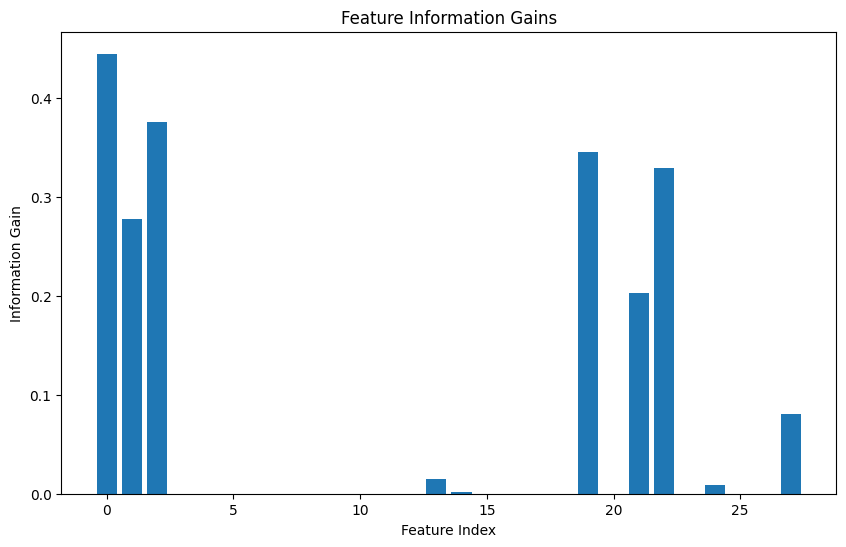

In [16]:
def extractattribute(model):
    gains = []
    if model.rightsub:
        gains.extend(extractattribute(model.rightsub))
    if model.leftsub:
        gains.extend(extractattribute(model.leftsub))
    if model.gain:
        gains.append((model.attribute, model.gain))
    return gains
attribute = extractattribute(model.root)
index, gain = zip(*attribute)
plt.figure(figsize=(10, 6))
plt.bar(index, gain)
plt.xlabel('Feature Index')
plt.ylabel('Information Gain')
plt.title('Feature Information Gains')
plt.show()

**Tuning the hyperparameters**

In [17]:
def tuning(Xtrain, Ytrain, Xtest, Ytest):
    max_depths = [3, 5, 7, 15, 20, 25]
    modes = ['gini', 'entropy']
    bestacc = 0
    params = {}
    for md in max_depths:
        for mode in modes:
            tree = DT(max_depth=md, mode=mode)
            tree.fit(Xtrain, Ytrain)
            Ypred = tree.predict(Xtest)
            acc = accuracy(Ytest, Ypred)
            if acc > bestacc:
                bestacc = acc
                params = {
                    'max_depth': md,
                    'mode': mode
                }
            print(f"Params: max_depth={md}, mode={mode}, Accuracy={acc}")

    print("\nBest Hyperparameters:")
    print(params)
    print(f"Best Accuracy: {bestacc}")

tuning(Xtrain, Ytrain, devXtest, devYtest)

Params: max_depth=3, mode=gini, Accuracy=0.9210526315789473
Params: max_depth=3, mode=entropy, Accuracy=0.9210526315789473
Params: max_depth=5, mode=gini, Accuracy=0.9210526315789473
Params: max_depth=5, mode=entropy, Accuracy=0.9298245614035088
Params: max_depth=7, mode=gini, Accuracy=0.9298245614035088
Params: max_depth=7, mode=entropy, Accuracy=0.9298245614035088
Params: max_depth=15, mode=gini, Accuracy=0.9298245614035088
Params: max_depth=15, mode=entropy, Accuracy=0.9298245614035088
Params: max_depth=20, mode=gini, Accuracy=0.9298245614035088
Params: max_depth=20, mode=entropy, Accuracy=0.9298245614035088
Params: max_depth=25, mode=gini, Accuracy=0.9298245614035088
Params: max_depth=25, mode=entropy, Accuracy=0.9298245614035088

Best Hyperparameters:
{'max_depth': 5, 'mode': 'entropy'}
Best Accuracy: 0.9298245614035088


**Model fitting with best GINI hyperparameters**

In [18]:
#Gini Tree
mg = DT(7, mode='gini')
mg.fit(Xtrain, Ytrain)

pregi = mg.predict(devXtest)

In [19]:
print(f"Model's Accuracy: {accuracy(devYtest, pregi)}")
print(f"Model's Confusion Matrix:")
recall, sp, p, f1, fpr, fnr, nvp = confusionMat(devYtest, pregi)
print(f"Recall: {recall}")
print(f"Specificity: {sp}")
print(f"Precision: {p}")
print(f"F1 Score: {f1}")
print(f"FPR Score: {fpr}")
print(f"FNR Score: {fnr}")
print(f"NVP Score: {nvp}")

Model's Accuracy: 0.9298245614035088
Model's Confusion Matrix:
Confusion Matrix:
[[67  4]
 [ 4 39]]
Confusion Matrix:
[[39  4]
 [ 4 67]]
Recall: 0.9069767441860465
Specificity: 0.9436619718309859
Precision: 0.9069767441860465
F1 Score: 0.9069767441860465
FPR Score: 0.056338028169014086
FNR Score: 0.09302325581395349
NVP Score: 0.9436619718309859


**Model fitting with best hyperparameters**

In [20]:
#Info_Gain Tree
mi = DT(5, mode='entropy')
mi.fit(Xtrain, Ytrain)

preig = mi.predict(devXtest)

print(f"Model's Accuracy: {accuracy(devYtest, preig)}")
print(f"Model's Confusion Matrix:")
recall, sp, p, f1, fpr, fnr, nvp = confusionMat(devYtest, preig)
print(f"Recall: {recall}")
print(f"Specificity: {sp}")
print(f"Precision: {p}")
print(f"F1 Score: {f1}")
print(f"FPR Score: {fpr}")
print(f"FNR Score: {fnr}")
print(f"NVP Score: {nvp}")

Model's Accuracy: 0.9298245614035088
Model's Confusion Matrix:
Confusion Matrix:
[[67  4]
 [ 4 39]]
Confusion Matrix:
[[39  4]
 [ 4 67]]
Recall: 0.9069767441860465
Specificity: 0.9436619718309859
Precision: 0.9069767441860465
F1 Score: 0.9069767441860465
FPR Score: 0.056338028169014086
FNR Score: 0.09302325581395349
NVP Score: 0.9436619718309859


**Performance Table**

In [21]:
giniaccuracy = accuracy(devYtest, pregi)
ginierror = 1 - giniaccuracy
grecall, gsp, gp, gf1, gfpr, gfnr, gnvp = confusionMat(devYtest, pregi)
giniprecision = gp
ginirecall = grecall

igaccuracy = accuracy(devYtest, preig)
igerror = 1 - igaccuracy
irecall, isp, ip, if1, ifpr, ifnr, invp = confusionMat(devYtest, preig)
igprecision = ip
igrecall = irecall

performancetable = pd.DataFrame({
    "Criterion": ["Gini", "Information Gain (IG)"],
    "Accuracy": [giniaccuracy, igaccuracy],
    "Error": [ginierror, igerror],
    "Precision": [giniprecision, igprecision],
    "Recall": [ginirecall, igrecall]
})

print(performancetable)

Confusion Matrix:
[[67  4]
 [ 4 39]]
Confusion Matrix:
[[39  4]
 [ 4 67]]
Confusion Matrix:
[[67  4]
 [ 4 39]]
Confusion Matrix:
[[39  4]
 [ 4 67]]
               Criterion  Accuracy     Error  Precision    Recall
0                   Gini  0.929825  0.070175   0.906977  0.906977
1  Information Gain (IG)  0.929825  0.070175   0.906977  0.906977


**Majority Class Classifier**

In [22]:
uniqueclass, count = np.unique(devYtest, return_counts=True)
majorityclass = uniqueclass[np.argmax(count)]

print("Majority class:", majorityclass)

ypredmajority = np.full_like(devYtest, majorityclass)
print(ypredmajority.shape)
print(devYtest.shape)

majorityacc = accuracy(devYtest, ypredmajority)
majorityerr = 1 - majorityacc
mrecall, msp, mp, mf1, mfpr, mfnr, mnvp = confusionMat(devYtest, ypredmajority)
majoritypre = mp
majorityrecall = mrecall

Majority class: 0
(114, 1)
(114, 1)
Confusion Matrix:
[[71  0]
 [43  0]]
Confusion Matrix:
[[ 0 43]
 [ 0 71]]


**Performance table for Majority Class Classifier**

In [23]:
performancetable = pd.DataFrame({
    "Criterion": ["Gini", "Information Gain (IG)", "Majority Class Baseline"],
    "Accuracy": [giniaccuracy, igaccuracy, majorityacc],
    "Error": [ginierror, igerror, majorityerr],
    "Precision": [giniprecision, igprecision, majoritypre],
    "Recall": [ginirecall, igrecall, majorityrecall]
})

print(performancetable)

                 Criterion  Accuracy     Error  Precision    Recall
0                     Gini  0.929825  0.070175   0.906977  0.906977
1    Information Gain (IG)  0.929825  0.070175   0.906977  0.906977
2  Majority Class Baseline  0.622807  0.377193   0.000000  0.000000


**Tesing with Best Hyperparameters**

In [24]:
test = pd.read_csv('wdbc_test_normalized.csv')
test['Diagnosis'] = (test['Diagnosis'] == 'M').astype(int)
names = test.columns[:-1].tolist()
Xtest = test[names].values
Ytest = test['Diagnosis'].values.reshape(-1,1)
testXtrain, testXtest, testYtrain, testYtest = randomsplit(Xtest, Ytest, randomstate=42, testsize=1)
mtg = DT(7, mode='gini')
mtg.fit(Xtrain, Ytrain)
py = mtg.predict(testXtest)
print(py)
print(f"Model's Accuracy: {accuracy(testYtest, py)}")
print(f"Model's Balanced Accuracy:")
recall, sp, p, f1, fpr, fnr, nvp = confusionMat(testYtest, py)
print(f"Recall: {recall}")
print(f"Specificity: {sp}")
print(f"Precision: {p}")
print(f"F1 Score: {f1}")
print(f"FPR Score: {fpr}")
print(f"FNR Score: {fnr}")
print(f"NVP Score: {nvp}")

[0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
Model's Accuracy: 0.9298245614035088
Model's Balanced Accuracy:
Confusion Matrix:
[[69  3]
 [ 5 37]]
Confusion Matrix:
[[37  5]
 [ 3 69]]
Recall: 0.8809523809523809
Specificity: 0.9583333333333334
Precision: 0.925
F1 Score: 0.9024390243902439
FPR Score: 0.041666666666666664
FNR Score: 0.11904761904761904
NVP Score: 0.9324324324324325


In [25]:
mt = DT(5, mode='entropy')
mt.fit(Xtrain, Ytrain)

pi = mt.predict(testXtest)
print(f"Model's Accuracy: {accuracy(testYtest, pi)}")
print(f"Model's Balanced Accuracy:")
recall, sp, p, f1, fpr, fnr, nvp = confusionMat(testYtest, pi)
print(f"Recall: {recall}")
print(f"Specificity: {sp}")
print(f"Precision: {p}")
print(f"F1 Score: {f1}")
print(f"FPR Score: {fpr}")
print(f"FNR Score: {fnr}")
print(f"NVP Score: {nvp}")

Model's Accuracy: 0.956140350877193
Model's Balanced Accuracy:
Confusion Matrix:
[[70  2]
 [ 3 39]]
Confusion Matrix:
[[39  3]
 [ 2 70]]
Recall: 0.9285714285714286
Specificity: 0.9722222222222222
Precision: 0.9512195121951219
F1 Score: 0.9397590361445782
FPR Score: 0.027777777777777776
FNR Score: 0.07142857142857142
NVP Score: 0.958904109589041


In [26]:
giniaccuracy = accuracy(testYtest, py)
ginierror = 1 - giniaccuracy
grecall, gsp, gp, gf1, gfpr, gfnr, gnvp = confusionMat(testYtest, py)
giniprecision = gp
ginirecall = grecall

igaccuracy = accuracy(testYtest, pi)
igerror = 1 - igaccuracy
irecall, isp, ip, if1, ifpr, ifnr, invp = confusionMat(testYtest, pi)
igprecision = ip
igrecall = irecall

performancetable = pd.DataFrame({
    "Criterion": ["Gini", "Information Gain (IG)", "Majority Class Baseline"],
    "Accuracy": [giniaccuracy, igaccuracy, majorityacc],
    "Error": [ginierror, igerror, majorityerr],
    "Precision": [giniprecision, igprecision, majoritypre],
    "Recall": [ginirecall, igrecall, majorityrecall]
})

print(performancetable)

Confusion Matrix:
[[69  3]
 [ 5 37]]
Confusion Matrix:
[[37  5]
 [ 3 69]]
Confusion Matrix:
[[70  2]
 [ 3 39]]
Confusion Matrix:
[[39  3]
 [ 2 70]]
                 Criterion  Accuracy     Error  Precision    Recall
0                     Gini  0.929825  0.070175    0.92500  0.880952
1    Information Gain (IG)  0.956140  0.043860    0.95122  0.928571
2  Majority Class Baseline  0.622807  0.377193    0.00000  0.000000


In [27]:
print(2 * (igprecision * igrecall)/(igprecision + igrecall))

0.9397590361445782
